<a href="https://colab.research.google.com/github/ocayaro/Orbital-Debris-Simulation/blob/main/Reentry_Simulation_5_for_Reviewers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


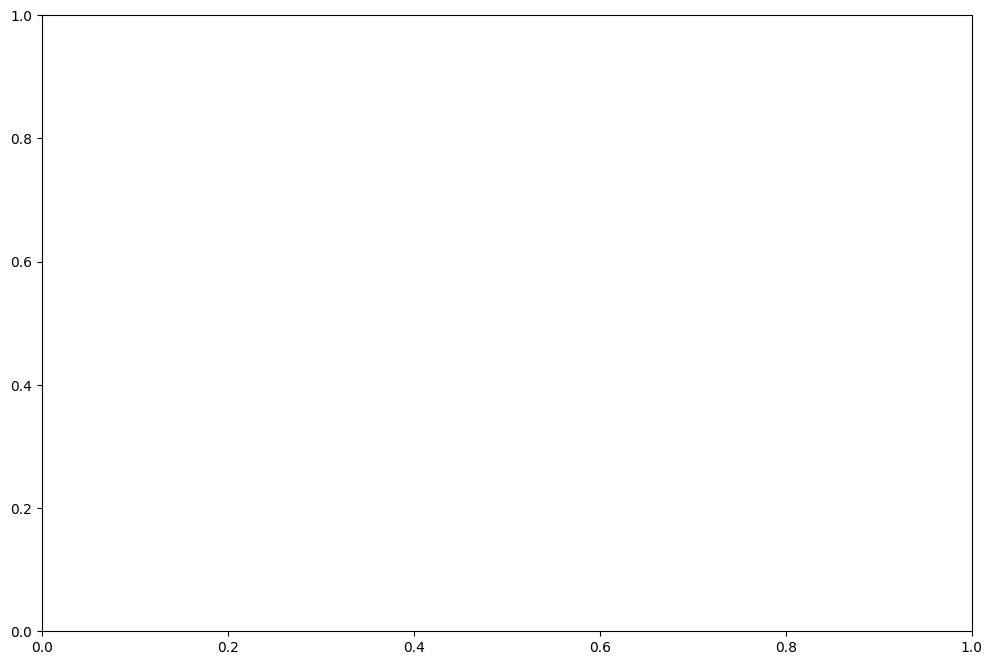

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# Space Object Reentry Trajectory Simulator (Corrected Version with Stable Initial Velocity)
!pip install -q geopandas numpy scipy matplotlib shapely pyatmos tqdm ipywidgets pint
!apt-get -qq install libspatialindex-dev
!pip install -q rtree

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from pyatmos import coesa76, nrlmsise00
from datetime import datetime, timedelta
import geopandas as gpd
from matplotlib.patches import FancyArrow
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from google.colab import drive, files
from pathlib import Path
import io
import pint
import os  # Import os for file path manipulation

# Create a unit registry
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity  # Shortcut for defining quantities with units
# I will come back to pint implementations later

# Constants
G = 6.67430e-11
M_earth = 5.972e24
R_earth = 6371e3
omega = 7.2921159e-5

class ReentrySimulator:
    def __init__(self, drag_coeff=2.2, mass=1000, area=10):
        self.drag_coeff = drag_coeff
        self.mass = mass
        self.area = area
        self.gravity_coeffs = {
            'J2': 1.08263e-3, 'J3': -2.5327e-6,
            'J4': -1.6196e-6, 'J5': -2.27e-7, 'J6': 5.406e-7
        }

    def simulate(self, initial_conditions, progress_callback=None):
        results = []
        summary = []

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # Get timestamp for filename
        SAVE_DIR = Path("/content/drive/MyDrive/ReentrySimulator")

        for i, (lat, lon, alt, vel, az, el) in enumerate(initial_conditions):  # example: [(0, 0, 120000, 7500, 0, -45)]
            print(f"\nSimulating Object {i+1}...")
            state = self._get_initial_state(lat, lon, alt, vel, az, el)
            t_span = (0, 7200)
            t_eval = np.linspace(*t_span, 1000)

            # Create CSV file for this object
            filename = os.path.join(SAVE_DIR, f"altitude_data_{timestamp}_{i+1}.csv")  # Construct filename
            with open(filename, 'w') as f:
                f.write("Time (s),Altitude (m)\n")  # Write header

            def wrapper(t, y):
                if progress_callback:
                    progress_callback(int(100 * t / t_span[1]))

                # Write time and altitude to CSV
                r = np.linalg.norm(y[:3])
                alt = r - R_earth
                with open(filename, 'a') as f:  # Append mode
                    f.write(f"{t:.1f},{alt:.1f}\n")
                return self._equations_of_motion(t, y)

            sol = solve_ivp(
                wrapper,
                t_span,
                state,
                method='RK45',
                events=self._landing_event,
                t_eval=t_eval,
                rtol=1e-6,
                atol=1e-9,
                dense_output=True
            )

            # sol.status:
            #	== 0 means the integrator successfully reached the time span.
            #	== 1 means sovler a terminal event fired e.g. landing.
            #	<  0 actual solver failure.

            if sol.status < 0:
                print(f"Solver failed: {sol.message}")
                continue
            if sol.t_events[0].size == 0:
                print(f"Warning: No landing event detected for object {i+1}.")
                continue
            if sol.sol is None:
                print(f"Warning: No interpolated solution returned for object {i+1}.")
                continue

            t_land = sol.t_events[0][0]
            t = np.linspace(0, t_land, 1000)
            solution = sol.sol(t)
            positions = solution[:3].T
            velocities = solution[3:].T
            r = np.linalg.norm(positions, axis=1)

            lats = np.degrees(np.arcsin(np.clip(positions[:, 2] / r, -1.0, 1.0)))
            # lats = np.degrees(np.arcsin(positions[:, 2] / r))

            lons = np.degrees(np.arctan2(positions[:, 1], positions[:, 0]))
            alts = r - R_earth
            v_end = velocities[-1]
            v_mag_end = np.linalg.norm(v_end)
            results.append((lats, lons, alts, velocities))

            summary.append({
                'Entry_Lat': lat, 'Entry_Lon': lon, 'Altitude_km': alt/1000,
                'Velocity_kmps': vel/1000, 'Azimuth': az, 'Elevation': el,
                'Landing_Lat': lats[-1], 'Landing_Lon': lons[-1],
                'Duration_sec': t_land, 'Impact_Speed_mps': v_mag_end
            })

        if not results:
            print("No valid simulations completed. Please check input parameters.")

        return results, pd.DataFrame(summary)

    def _get_initial_state(self, lat, lon, alt, vel, az, el):
        lat_rad = np.radians(lat)
        lon_rad = np.radians(lon)
        az_rad = np.radians(az)
        el_rad = np.radians(el)

        x = (R_earth + alt) * np.cos(lat_rad) * np.cos(lon_rad)
        y = (R_earth + alt) * np.cos(lat_rad) * np.sin(lon_rad)
        z = (R_earth + alt) * np.sin(lat_rad)

        east = np.array([-np.sin(lon_rad), np.cos(lon_rad), 0])
        north = np.array([
            -np.sin(lat_rad) * np.cos(lon_rad),
            -np.sin(lat_rad) * np.sin(lon_rad),
             np.cos(lat_rad)
        ])
        up = np.array([
            np.cos(lat_rad) * np.cos(lon_rad),
            np.cos(lat_rad) * np.sin(lon_rad),
            np.sin(lat_rad)
        ])

        v_enu = (
            vel * np.cos(el_rad) * np.cos(az_rad) * north +
            vel * np.cos(el_rad) * np.sin(az_rad) * east +
            vel * np.sin(el_rad) * up
        )

        return np.concatenate(([x, y, z], v_enu))

    def _equations_of_motion(self, t, state):
        if int(t) % 100 == 0:
            r = np.linalg.norm(state[:3])
            alt = r - R_earth
            print(f"t = {t:.1f} s, altitude = {alt:.1f} m")
        x, y, z, vx, vy, vz = state
        r_vec = np.array([x, y, z])
        r = np.linalg.norm(r_vec)
        alt = r - R_earth

        '''
        lat = np.arcsin(z / r) is the correct approach only if
        positions[:, 2]/r stays within [-1, 1]. In practice, numerical errors
        (especially near poles), causes arcsin() to return nan or invalid values
        like >90 or <-90. To ensure latitude calculations are always valid,
        wrap the division with np.clip(..., -1, 1)

        '''
        lat = np.arcsin(np.clip(z / r, -1.0, 1.0))
        lon = np.arctan2(y, x)

        sin_lat = np.sin(lat)
        cos_lat = np.cos(lat)
        r_ratio = R_earth / r

        grav_perturb = (
            1 +
            self.gravity_coeffs['J2'] * (3*sin_lat**2 - 1) * r_ratio**2 / 2 +
            self.gravity_coeffs['J3'] * (5*sin_lat**3 - 3*sin_lat) * r_ratio**3 / 2 +
            self.gravity_coeffs['J4'] * (35*sin_lat**4 - 30*sin_lat**2 + 3) * r_ratio**4 / 8 +
            self.gravity_coeffs['J5'] * (63*sin_lat**5 - 70*sin_lat**3 + 15*sin_lat) * r_ratio**5 / 8 +
            self.gravity_coeffs['J6'] * (231*sin_lat**6 - 315*sin_lat**4 + 105*sin_lat**2 - 5) * r_ratio**6 / 16
        )
        a_grav = -G * M_earth * r_vec / r**3 * grav_perturb

        try:
            atmos = nrlmsise00(datetime.now(), (alt / 1000.0, np.degrees(lat), np.degrees(lon)))
            # Note that both nrlmsise00 and coesa76 expects altitude in km
            rho = atmos.rho
        except:
            rho = coesa76(alt/1000).rho if alt > 0 else 1e-15
        if not np.isfinite(rho) or rho < 1e-20:
            rho = 1e-15

        wind = self._get_wind(alt, np.degrees(lat))
        wind_xyz = np.array([
            -wind[0]*np.sin(lon) - wind[1]*np.sin(lat)*np.cos(lon),
            wind[0]*np.cos(lon) - wind[1]*np.sin(lat)*np.sin(lon),
            wind[1]*np.cos(lat)
        ])
        v_rel = np.array([vx, vy, vz]) - np.array([-omega*y, omega*x, 0]) - wind_xyz
        v_rel_mag = np.linalg.norm(v_rel)
        a_drag = -0.5 * self.drag_coeff * rho * v_rel_mag * v_rel * self.area / self.mass

        return np.concatenate(([vx, vy, vz], a_grav + a_drag))

    def _get_wind(self, alt, lat):
        if alt <= 15e3:
            return [30*np.cos(2*np.pi*lat/180), 10*np.sin(2*np.pi*lat/180)]
        elif alt <= 50e3:
            return [20*np.sin(np.pi*lat/90), 5*np.cos(np.pi*lat/90)]
        return [0, 0]

    def _landing_event(self, t, state):
        r = np.linalg.norm(state[:3])
        alt = r - R_earth
        return alt - 100.0 # landing event triggered at 100 m
    _landing_event.terminal = True
    _landing_event.direction = -1


class TrajectoryVisualizer:
    def __init__(self, simulator):  # Add simulator argument to constructor
        self.fig, self.ax = plt.subplots(figsize=(12, 8))
        self._load_world_map()
        self.simulator = simulator  # Store simulator instance

    def _load_world_map(self):
        try:
            # Try to load world map data
            world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
            self.world = world
        except:
            try:
                # Fallback to direct download
                world = gpd.read_file('https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip')
                self.world = world
            except Exception as e:
                print(f"Warning: Could not load world map - {str(e)}")
                self.world = None

    # Add scenarios argument
    def plot(self, trajectory_data, scenarios, title='Space Object Reentry Trajectories'):
        self.ax.clear()

        # Plot world map if available
        if self.world is not None:
            self.world.plot(ax=self.ax, color='lightgray', edgecolor='gray', alpha=0.7)

        # Color and marker options
        colors = plt.cm.tab10.colors
        markers = ['*', 's', 'D', '^', 'o', 'p', 'h', 'v', '<', '>']

        # Plot each trajectory
        # print(trajectory_data)  # Add this line for debugging
        for i, (lats, lons, alts, velocities) in enumerate(trajectory_data):
            if len(lats) == 0:
                continue

            # Plot trajectory
            color = colors[i % len(colors)]
            self.ax.plot(lons, lats, color=color, linewidth=2.5,
                         label=f'Object {i+1}', zorder=3)

            # Mark start and end points
            marker = markers[i % len(markers)]
            self.ax.scatter(lons[0], lats[0], color=color, s=150,
                           marker=marker, edgecolor='k', zorder=4)
            self.ax.scatter(lons[-1], lats[-1], color=color, s=150,
                           marker='X', edgecolor='k', zorder=4)
        self._format_plot(title)
        plt.tight_layout()

        return self.fig

    def _format_plot(self, title):
        self.ax.set_title(title, fontsize=14)
        self.ax.set_xlabel('Longitude (°)', fontsize=12)
        self.ax.set_ylabel('Latitude (°)', fontsize=12)
        self.ax.grid(True, alpha=0.3)
    #   print(self.ax.get_legend_handles_labels()) # debugging
    #   self.ax.legend(loc='upper right', fontsize=10)

        # Add informational annotation
        info_text = "X = Landing Locations"
        self.ax.annotate(info_text, xy=(0.02, 0.05), xycoords='axes fraction',
                        fontsize=10, bbox=dict(boxstyle='round', alpha=0.5))

def create_colab_interface():
    # Mount Google Drive
    drive.mount('/content/drive')
    SAVE_DIR = Path("/content/drive/MyDrive/ReentrySimulator")
    SAVE_DIR.mkdir(parents=True, exist_ok=True)

    # Create simulator and visualizer instances
    simulator = ReentrySimulator()
    visualizer = TrajectoryVisualizer(simulator) # Pass simulator instance here

    # Create widgets
    style = {'description_width': '150px'}
    layout = widgets.Layout(width='95%')

    # Main parameters
    lat_slider = widgets.FloatSlider(
        description='Latitude (°)', min=-90, max=90, step=0.1, value=0,
        style=style, layout=layout)
    lon_slider = widgets.FloatSlider(
        description='Longitude (°)', min=-180, max=180, step=0.1, value=0,
        style=style, layout=layout)
    alt_slider = widgets.FloatSlider(
        description='Altitude (km)', min=80, max=200, step=1, value=100,
        style=style, layout=layout)
    vel_slider = widgets.FloatSlider(
        description='Velocity (km/s)', min=1, max=8, step=0.1, value=7.5,
        style=style, layout=layout)
    az_slider = widgets.FloatSlider(
        description='Azimuth (°)', min=0, max=360, step=1, value=0,
        style=style, layout=layout)
    el_slider = widgets.FloatSlider(
        description='Elevation (°)', min=-90, max=90, step=1, value=-5,
        style=style, layout=layout)

    # Object properties
    mass_slider = widgets.FloatSlider(
        description='Mass (kg)', min=10, max=10000, step=10, value=1000,
        style=style, layout=layout)
    area_slider = widgets.FloatSlider(
        description='Area (m²)', min=0.1, max=100, step=0.1, value=10,
        style=style, layout=layout)
    cd_slider = widgets.FloatSlider(
        description='Drag Coefficient', min=0.1, max=3, step=0.1, value=2.2,
        style=style, layout=layout)

    # File upload
    upload_button = widgets.FileUpload(
        accept='.csv', multiple=False,
        description='Upload CSV', layout=widgets.Layout(width='300px'))

    # Buttons
    run_button = widgets.Button(
        description='Run Simulation',
        button_style='success', layout=widgets.Layout(width='200px'))
    save_button = widgets.Button(
        description='Save Results',
        button_style='info', layout=widgets.Layout(width='200px'))

    # Progress bar
    progress_bar = widgets.FloatProgress(
        value=0, min=0, max=100, step=1,
        description='Progress:', bar_style='info',
        orientation='horizontal', layout=widgets.Layout(width='95%'))

    # Output area
    output = widgets.Output()

    def update_progress(progress):
        progress_bar.value = progress

    def on_run_button_clicked(b):
        with output:
            clear_output()

            # Update simulator parameters
            simulator.mass = mass_slider.value
            simulator.area = area_slider.value
            simulator.drag_coeff = cd_slider.value

            # Initialize simulation_scenarios
            global simulation_scenarios
            simulation_scenarios = [] # Initialize the variable

            # Prepare scenarios
            if upload_button.value:
                # Process uploaded CSV
                for filename in upload_button.value:
                    content = upload_button.value[filename]['content']
                    df = pd.read_csv(io.BytesIO(content))

                    # Check required columns
                    required_cols = ['Latitude', 'Longitude', 'Altitude',
                                  'Velocity', 'Azimuth', 'Elevation']
                    if all(col in df.columns for col in required_cols):
                        scenarios = df[required_cols].values.tolist()
                        # Convert altitude from km to m and velocity from km/s to m/s
                        simulation_scenarios = [(lat, lon, alt*1000, vel*1000, az, el)
                                  for lat, lon, alt, vel, az, el in scenarios]
                    else:
                        print(f"Error: CSV must contain these columns: {', '.join(required_cols)}")
                        # Clear the file upload so the user can try again
                        upload_button.value = {}
                        return
            else:
                # Use slider values (convert km to m)
                simulation_scenarios = [(
                    lat_slider.value, lon_slider.value,
                    alt_slider.value*1000,
                    vel_slider.value*1000,
                    az_slider.value, el_slider.value
                )]

            # Proceed with simulation only if scenarios are defined
            if simulation_scenarios:
                # Run simulation with progress updates
                print("Running simulation...")
                results, summary = simulator.simulate(simulation_scenarios, progress_callback=update_progress)

                # Display results
                display(visualizer.plot(results, simulation_scenarios, title='Space Object Reentry Trajectories'))

                display(summary)

                # Save results to variables for download
                global simulation_results, simulation_summary
                simulation_results = results
                simulation_summary = summary

                # Save to Google Drive
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                summary_path = SAVE_DIR / f"reentry_summary_{timestamp}.csv"
                summary.to_csv(summary_path, index=False)
                print(f"\nResults saved to Google Drive: {summary_path}")

                # Reset progress bar
                progress_bar.value = 0
            else:
                print("No valid simulation scenarios provided.")

    def on_save_button_clicked(b):
        with output:
            clear_output()
            global simulation_results, simulation_summary, simulation_scenarios # Add global declaration here
            if 'simulation_summary' not in globals():
                print("No simulation results to save. Run a simulation first.")
                return
            if 'simulation_scenarios' not in globals(): # Check if scenarios exist
                print("No simulation scenarios saved. Run a simulation first.")
                return

            # Save plot
            fig = visualizer.plot(simulation_results, simulation_scenarios) # Pass simulation_scenarios here
            plot_path = SAVE_DIR / f"reentry_plot_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
            fig.savefig(plot_path, dpi=600, bbox_inches='tight')
            print(f"Plot saved to Google Drive: {plot_path}")

            # Offer download
            summary_csv = simulation_summary.to_csv(index=False)
            from IPython.display import Javascript
            display(Javascript('''
                var content = %s;
                var blob = new Blob([content], {type: 'text/csv'});
                var a = document.createElement('a');
                a.href = URL.createObjectURL(blob);
                a.download = 'reentry_summary.csv';
                document.body.appendChild(a);
                a.click();
                document.body.removeChild(a);
            ''' % (repr(summary_csv))))
            print("Summary CSV downloaded to your local machine.")

    # Connect buttons to functions
    run_button.on_click(on_run_button_clicked)
    save_button.on_click(on_save_button_clicked)

    # Create tab interface
    tab = widgets.Tab()
    tab.children = [
        widgets.VBox([
            widgets.HTML("<h3>Single Object Simulation</h3>"),
            widgets.HBox([lat_slider, lon_slider]),
            widgets.HBox([alt_slider, vel_slider]),
            widgets.HBox([az_slider, el_slider]),
            widgets.HTML("<h4>Object Properties</h4>"),
            mass_slider, area_slider, cd_slider,
            run_button
        ]),
        widgets.VBox([
            widgets.HTML("<h3>Batch Simulation from CSV</h3>"),
            widgets.HTML("""
                <p>Upload a CSV file with columns:<br>
                <code>Latitude, Longitude, Altitude (km), Velocity (km/s), Azimuth (°), Elevation (°)</code></p>
            """),
            upload_button,
            widgets.HTML("<h4>Object Properties</h4>"),
            mass_slider, area_slider, cd_slider,
            run_button
        ])
    ]
    tab.set_title(0, 'Single Simulation')
    tab.set_title(1, 'Batch Simulation')

    # Display the full interface
    display(widgets.VBox([
        tab,
        progress_bar,
        save_button,
        output
    ]))

# Run the interface
create_colab_interface()